# Introduction to Recommendation Systems and Factorization Machines

## Prerequisites

* Preliminaries:
    * Classification
    * Classification Metrics

## Learning Goals

By the end of this lecture a student should be able to:

* Explain what the metrics MAP and MAR are.
* Explain how to use Collaborative Filtering to build a Recommendation System.

Above and Beyond:

* Explain how to use a field-aware factorization machine to build a Recommendation System.


----



## Typical Approaches

### Simple (Popularity) Recommender

The Simple Recommender offers generalized recommendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. 

* *Note:* This model does **NOT** give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

### Content Based Recommender

The simple recommender suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 10 Chart, he/she wouldn't probably like most of the movies. If they were to go one step further and look at our charts by genre, they still wouldn't be getting the best recommendations.

For instance, consider a person who loves *Edward Scissorhands*, *Sweeney Todd* and *Corpse Bride*. One inference we can obtain is that the person loves the actor Johnny Depp and the director Tim Burton. Even if they were to access the Fantasy/Horror/Mystery charts, this person would not find *Sleepy Hollow* in the recommendations.

To personalise our recommendations more, we can build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

We could easily build two Content Based Recommenders:

* One based on Movie Overviews and Taglines,
* One based on Movie Cast, Crew, Keywords and Genre

### Collaborative Filtering

The content based approach suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in the sense that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who they are.

Ergo, we need something beyond what we have done. One such way to mitigate these potential pitfalls is to introduce Collaborative Filtering to make recommendations to viewers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have experienced (but I have not).

We will not be implementing Collaborative Filtering from scratch. Instead, we will use the *Surprise* library which has algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

### Hybrid Models

Putting all of the above mentioned ideas together can make for an extremely effective model. Typically when people say they are using a hybrid model for recommendation, their ingredients are: 
* a simple recommender,
* content-based recommenders,
* and collaborative filtering.

However, there are more modern recommender systems / approaches available. And a hybrid model could also possibly include those as well (but it is not likely).

### Topic-based (Meta-based) Recommenders

Typically these incorporate ideas from NLP, Deep Learning, Representation Learning, Manifold Learning, etc.

### Field-Aware Factorization Machines

This is la creme de la creme of the statistical hybrid approaches. The idea of a factorization machine is simple:

$$
\textrm{Ratings} = \big(\textrm{Users-by-Features}\big) \big(\textrm{Movies-by-Features}\big)^\top .
$$
That is,
$$
R = P \cdot Q^\top .
$$

But we have pairwise interactions in this which are treated too simply / naively. The FFM extension of FM's is simply to make the pairwise interactions aware of fields. See "Further Reading" for more on this subject.

## Imports

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from surprise import Reader, NormalPredictor, BaselineOnly, KNNBasic, SVD, SVDpp, NMF, Dataset
from surprise.model_selection import train_test_split

import gc; gc.enable()

In [312]:
# data is from here:
# https://grouplens.org/datasets/movielens/20m/

## Helper Functions

I stole most of these from a single source... but I lost the link. 

*TODO*: Add Reference.

In [494]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from funcsigs import signature


def coverage_plot(coverage_scores, model_names):
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df, dashes=False)
    plt.xticks(k_range)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df, dashes=False)
    plt.xticks(k_range)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()



def class_separation_plot(pred_df, n_bins=150, threshold=None, figsize=(10,6), title=None):
    """
    Plots the predicted class probabilities for multiple classes.
    Usefull for visualizing predicted interaction values such as 5 star ratings, where a "class" is a star rating,
    or visualizing predicted class probabilities for binary classification model or recommender system.
    The true class states are colored.
    ----------
    pred_df: pandas dataframe
        a dataframe containing a column of predicted interaction values or classification probabilites,
        and a column of true class 1 and class 0 states.
        This dataframe must contain columns named "predicted" and "truth"
        example:
        	predicted | truth
        	5.345345	|  5
        	2.072020	|  2
    n_bins: number of bins for histogram.
    threshold: float. default = 0.5
        A single number between 0 and 1 identifying the threshold to classify observations to class
        example: 0.5
    figsize: size of figure
    title: plot title
    Returns:
    -------
        A classification probability plot
    """
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF", "#FC5FA3"]
    classes = pred_df.truth.unique()
    plt.figure(figsize=figsize)
    for i in range(len(classes)):
        single_class = classes[i]
        sns.distplot( pred_df.query("truth == @single_class")["predicted"] , bins=n_bins, color=recommender_palette[i], label="True {}".format(single_class))
    plt.legend()
    if threshold == None: pass
    else: plt.axvline(threshold, color="black", linestyle='--')
    plt.xlabel("Predicted value")
    plt.ylabel("Frequency")
    if title == None: plt.title(" ")
    else: plt.title(title)
    plt.show()


def roc_plot(actual, model_probs, model_names, figsize=(10,10)):
    """
    Receiver Operating Characteristic Plot. Can plot multiple models.
    ----------
    actual: array of dataframe of true classes assignements.
        example:
        [1,1,0,1,0]
    model_probs: list of arrays
        a list containing classification probabilites for each model in order.
        example:
        model_probs = [class_probs_1, class_probs_2]
    model_names: list of strings
        a list containing names for each model in order.
        example:
        model_names = ["GBT", "Logistic Regression"]
    figsize: size of figure
    Returns:
    -------
        Receiver Operating Characteristic Plot with AUC in the legend.
    """
    model_names = make_listy(model_names)
    if not is_listy(model_probs): model_probs = [model_probs]

    if len(model_names) > 5:
        return ValueError("Can only compare 5 models or less.")

    colors = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_title('Receiver Operating Characteristic Plot')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    for m in range(len(model_names)):
        fpr, tpr, threshold = roc_curve(actual, model_probs[m])
        roc_auc = auc(fpr, tpr)
        ax = sns.lineplot(x=fpr,
                          y=tpr,
                          lw=2,
                          color=colors[m],
                          label = model_names[m] + ' AUC = %0.4f' % roc_auc)
    plt.show()


def precision_recall_plot(targs, preds, figsize=(6,6)):
    """
    Plots the precision recall curve
    ----------
    targs: array-like true class labels
    preds: array-like predicted probabilities
    figsize: size of figure

    Returns:
    -------
        A precision and recall curve
    """
    average_precision = average_precision_score(targs, preds)
    precision, recall, _ = precision_recall_curve(targs, preds)
    plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
    plt.show()


def make_listy(p):
    if isinstance(p, str): return [p]
    try:
        _ = iter(p)
    except TypeError:
        p = [p]
    return p


def is_listy(x): return isinstance(x, (tuple,list))


In [471]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random


def prediction_coverage(predicted, catalog):
    """
    Computes the prediction coverage for a list of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    Returns
    ----------
    prediction_coverage:
        The prediction coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_predictions = len(set(predicted_flattened))
    prediction_coverage = round(unique_predictions/(len(catalog)* 1.0)*100,2)
    return prediction_coverage

def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

def _ark(actual, predicted, k=10):
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : int
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)

def mark(actual, predicted, k=10):
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: int
            The mean average recall at k (mar@k)
    """
    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def _apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])


def personalization(predicted):
    """
    Personalization measures recommendation similarity across users.
    A high score indicates good personalization (user's lists of recommendations are different).
    A low score indicates poor personalization (user's lists of recommendations are very similar).
    A model is "personalizing" well if the set of recommendations for each user is different.
    Parameters:
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        The personalization score for all recommendations.
    """

    def make_rec_matrix(predicted):
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = df.mask(pd.notna(df), 1)
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    #create matrix for recommendations
    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    #calculate similarity for every user's recommendation list
    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity
    personalization = np.mean(similarity[upper_right])
    return 1-personalization

def _single_list_similarity(predicted, feature_df):
    """
    Computes the intra-list similarity for a single list of recommendations.
    Parameters
    ----------
    predicted : a list
        Ordered predictions
        Example: ['X', 'Y', 'Z']
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
    ils_single_user: float
        The intra-list similarity for a single list of recommendations.
    """
    #get features for all recommended items
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    #calculate similarity scores for all items in list
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)

    #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted, feature_df):
    """
    Computes the average intra-list similarity of all recommendations.
    This metric can be used to measure diversity of the list of recommended items.
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        Example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    feature_df: dataframe
        A dataframe with one hot encoded or latent features.
        The dataframe should be indexed by the id used in the recommendations.
    Returns:
    -------
        The average intra-list similarity for recommendations.
    """
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    ils = [_single_list_similarity(predicted[u], feature_df) for u in Users]
    return np.mean(ils)

def mse(y, yhat):
    """
    Computes the mean square error (MSE)
    Parameters
    ----------
    yhat : Series or array. Reconstructed (predicted) ratings or interaction values.
    y: original true ratings or interaction values.
    Returns:
    -------
        The mean square error (MSE)
    """
    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y, yhat):
    """
    Computes the root mean square error (RMSE)
    Parameters
    ----------
    yhat : Series or array. Reconstructed (predicted) ratings or values
    y: original true ratings or values.
    Returns:
    -------
        The mean square error (MSE)
    """
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

def make_confusion_matrix(y, yhat):
    """
    Calculates and plots a confusion matrix
    Parameters
    ----------
    y : list or array of actual interaction values such as ratings
    yhat: list or array of actual predicted interaction values
    Returns:
    -------
        A confusion matrix plot
    """
    cm = confusion_matrix(y, yhat, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = ".2f"
    thresh = cm.max() / 2.
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])
    plt.show()


def recommender_precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual):
        prec = [value for value in predicted if value in actual]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        return prec

    precision = np.mean(list(map(calc_precision, predicted, actual)))
    return precision


def recommender_recall(predicted, actual):
    """
    Computes the recall of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        recall: int
    """
    def calc_recall(predicted, actual):
        reca = [value for value in predicted if value in actual]
        reca = np.round(float(len(reca)) / float(len(actual)), 4)
        return reca

    recall = np.mean(list(map(calc_recall, predicted, actual)))
    return recall


## Peek at the Data

In [362]:
PATH = '../data/ml-20m/ml-20m/'

ratings = pd.read_csv(PATH+'ratings.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819


### Limit to Higher Ratings

In [363]:
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

### Limit to More Frequent Raters

In [364]:
n = 1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()
users[:5]

[118205, 125794, 8405, 131904, 82418]

In [365]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


## Movie Features

In [366]:
rated_movies = ratings.movieId.tolist()

movies = pd.read_csv(PATH+'movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

titles = movies.title.tolist()
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [367]:
movies = movies.genres.str.get_dummies()
movies['title'] = titles

movies.reset_index(inplace=True)
movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Toy Story (1995)
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Jumanji (1995)
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Grumpier Old Men (1995)
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,Waiting to Exhale (1995)
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Father of the Bride Part II (1995)


In [368]:
titles = movies.title.tolist()
del movies['title']; gc.collect();

## Surprise Recommenders

### Data Prep

In [451]:
# format data for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# this is surprise's train_test_split
#  --NOT scikit-learn's
trainset, testset = train_test_split(data, test_size=0.25)

### Surprise's Trainset Object

In [452]:
trainset.all_users()

range(0, 933)

In [453]:
trainset.all_items()

range(0, 20967)

In [454]:
trainset.global_mean

3.758657198414449

In [455]:
trainset.n_ratings

988426

In [456]:
trainset.n_users

933

In [457]:
trainset.n_items

20967

In [458]:
# trainset.ur
# trainset.ir

### Collaborative Filtering via SVD (Factorization)

In [459]:
# train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [460]:
# make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'svd']
test.head()

,userId,movieId,actual,svd
0,111880,36401,3.0,3.256070
1,10164,4941,3.0,3.541366
2,92706,48394,5.0,4.171330
3,130191,2456,5.0,3.628954
4,112988,2355,4.0,3.609401


### Various Approaches

In [461]:
# Baseline
algo = BaselineOnly()
algo.fit(trainset)
test['baseline'] = pd.DataFrame(algo.test(testset))['est']

# Normal
algo = NormalPredictor()
algo.fit(trainset)
test['normal'] = pd.DataFrame(algo.test(testset))['est']

# Collaborative Filtering
algo = KNNBasic()
algo.fit(trainset)
test['cf'] = pd.DataFrame(algo.test(testset))['est']

# This is expensive...
# SVD++
# algo = SVDpp()
# algo.fit(trainset)
# test['svdpp'] = pd.DataFrame(algo.test(testset))['est']

# NMF
algo = NMF()
algo.fit(trainset)
test['nmf'] = pd.DataFrame(algo.test(testset))['est']

test.head()

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,userId,movieId,actual,svd,baseline,normal,cf,nmf
0,111880,36401,3.0,3.256070,3.205513,2.435910,3.410272,3.184622
1,10164,4941,3.0,3.541366,3.540683,4.172756,3.437337,3.517905
2,92706,48394,5.0,4.171330,4.109008,4.134380,4.189162,4.207343
3,130191,2456,5.0,3.628954,3.751108,3.399296,3.451729,3.627661
4,112988,2355,4.0,3.609401,3.622433,2.854716,3.685754,3.605597


### Rating Matrices

In [462]:
models = [
    'svd', 'baseline', 'normal', 'cf', 
#           'svdpp',
    'nmf'
]
matrices = []

for model in models:
    rating_matrix = test.pivot_table(index='userId', 
                                columns='movieId', 
                                values=model).fillna(0)
    matrices.append(rating_matrix)
    gc.collect();

In [463]:
matrices[0].head()

movieId,1,2,3,4,5,6,7,8,9,10,...,131106,131108,131110,131118,131132,131136,131144,131148,131150,131250
userId,,,,,,,,,,,,,,,,,,,,,
156,0.000000,3.685985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.126237,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,4.210542,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [464]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [465]:
# format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

for i, model in enumerate(models):
    # make recommendations for all members in the test data
    recs = []
    for user in test.index:
        predictions = get_users_predictions(user, 10, matrices[i])
        recs.append(predictions)
        
    test[model+'_pred'] = recs

test.head(3)

C:\Users\purem\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


,actual,svd_pred,baseline_pred,normal_pred,cf_pred,nmf_pred
userId,,,,,,
156,"[2, 4103, 2057, 11, 2070, 2071, 32, 34, 6184, ...","[1196, 356, 527, 1234, 50, 1214, 457, 1097, 12...","[296, 527, 50, 1196, 904, 1208, 1089, 541, 121...","[4610, 2600, 5307, 5200, 3176, 3505, 2803, 205...","[1196, 527, 296, 50, 1234, 1089, 1214, 904, 54...","[904, 50, 541, 296, 111, 1209, 1269, 1089, 527..."
208,"[1537, 1, 4612, 517, 55814, 2567, 1544, 4103, ...","[912, 26587, 3739, 922, 1208, 593, 1230, 111, ...","[1198, 912, 593, 1196, 26587, 3739, 922, 4226,...","[32160, 3091, 471, 1270, 3819, 3788, 5450, 118...","[912, 3739, 922, 1208, 1207, 1198, 6016, 26587...","[593, 26587, 3739, 3022, 955, 745, 905, 950, 9..."
359,"[1027, 2565, 4103, 44555, 1035, 11, 67087, 507...","[1221, 260, 593, 7502, 1208, 1258, 47, 4226, 1...","[1221, 593, 7502, 4226, 260, 3307, 1208, 44555...","[994, 5349, 1707, 553, 26084, 1994, 41569, 196...","[1221, 7502, 260, 44555, 3307, 593, 47, 899, 1...","[1221, 593, 3307, 47, 541, 44555, 260, 7502, 1..."


## More Baselines

### Popularity Recommender

In [466]:
# make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_pred'] = recs
test.head(3)

,actual,svd_pred,baseline_pred,normal_pred,cf_pred,nmf_pred,pop_pred
userId,,,,,,,
156,"[2, 4103, 2057, 11, 2070, 2071, 32, 34, 6184, ...","[1196, 356, 527, 1234, 50, 1214, 457, 1097, 12...","[296, 527, 50, 1196, 904, 1208, 1089, 541, 121...","[4610, 2600, 5307, 5200, 3176, 3505, 2803, 205...","[1196, 527, 296, 50, 1234, 1089, 1214, 904, 54...","[904, 50, 541, 296, 111, 1209, 1269, 1089, 527...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[1537, 1, 4612, 517, 55814, 2567, 1544, 4103, ...","[912, 26587, 3739, 922, 1208, 593, 1230, 111, ...","[1198, 912, 593, 1196, 26587, 3739, 922, 4226,...","[32160, 3091, 471, 1270, 3819, 3788, 5450, 118...","[912, 3739, 922, 1208, 1207, 1198, 6016, 26587...","[593, 26587, 3739, 3022, 955, 745, 905, 950, 9...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[1027, 2565, 4103, 44555, 1035, 11, 67087, 507...","[1221, 260, 593, 7502, 1208, 1258, 47, 4226, 1...","[1221, 593, 7502, 4226, 260, 3307, 1208, 44555...","[994, 5349, 1707, 553, 26084, 1994, 41569, 196...","[1221, 7502, 260, 44555, 3307, 593, 47, 899, 1...","[1221, 593, 3307, 47, 541, 44555, 260, 7502, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


### Random Recommender

In [467]:
# make recommendations for all members in the test data
recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_pred'] = recs
test.head(3)

,actual,svd_pred,baseline_pred,normal_pred,cf_pred,nmf_pred,pop_pred,random_pred
userId,,,,,,,,
156,"[2, 4103, 2057, 11, 2070, 2071, 32, 34, 6184, ...","[1196, 356, 527, 1234, 50, 1214, 457, 1097, 12...","[296, 527, 50, 1196, 904, 1208, 1089, 541, 121...","[4610, 2600, 5307, 5200, 3176, 3505, 2803, 205...","[1196, 527, 296, 50, 1234, 1089, 1214, 904, 54...","[904, 50, 541, 296, 111, 1209, 1269, 1089, 527...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[8640, 3051, 3101, 165, 5679, 5500, 315, 3871,..."
208,"[1537, 1, 4612, 517, 55814, 2567, 1544, 4103, ...","[912, 26587, 3739, 922, 1208, 593, 1230, 111, ...","[1198, 912, 593, 1196, 26587, 3739, 922, 4226,...","[32160, 3091, 471, 1270, 3819, 3788, 5450, 118...","[912, 3739, 922, 1208, 1207, 1198, 6016, 26587...","[593, 26587, 3739, 3022, 955, 745, 905, 950, 9...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3675, 328, 2455, 3844, 5875, 2403, 2261, 7169..."
359,"[1027, 2565, 4103, 44555, 1035, 11, 67087, 507...","[1221, 260, 593, 7502, 1208, 1258, 47, 4226, 1...","[1221, 593, 7502, 4226, 260, 3307, 1208, 44555...","[994, 5349, 1707, 553, 26084, 1994, 41569, 196...","[1221, 7502, 260, 44555, 3307, 593, 47, 899, 1...","[1221, 593, 3307, 47, 541, 44555, 260, 7502, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[5046, 1591, 4643, 569, 6216, 2761, 7020, 5225..."


## Model Evaluation

In [468]:
models = [
    'svd', 'baseline', 'normal', 'cf', 
#           'svdpp',
    'nmf', 'pop', 'random'
]

marks = []
mapks = []
predictions = []
for model in models:
    prediction = test[model+"_pred"]
    mark_list = []
    mapk_list = []
    for K in np.arange(1, 11):
        mark_list.extend([mark(actual, prediction, k=K)])
        mapk_list.extend([mapk(actual, prediction, k=K)])
    marks.append(mark_list)
    mapks.append(mapk_list)
    predictions.append(prediction)

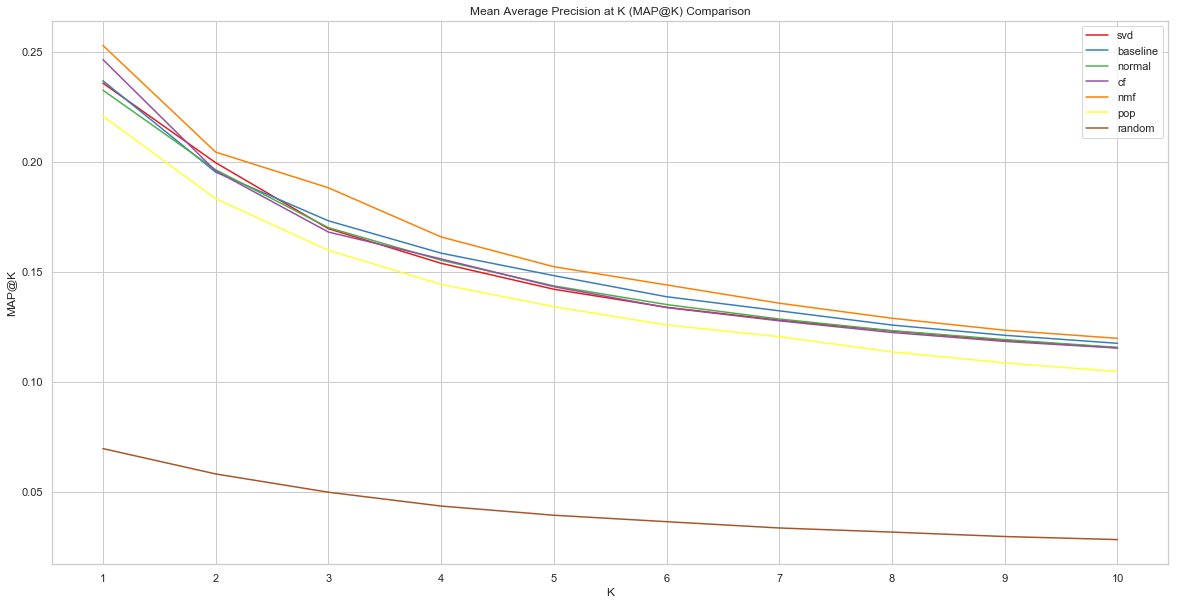

In [495]:
index = range(1,10+1)

fig = plt.figure(figsize=(20, 10))
mapk_plot(mapks, model_names=models, k_range=index)

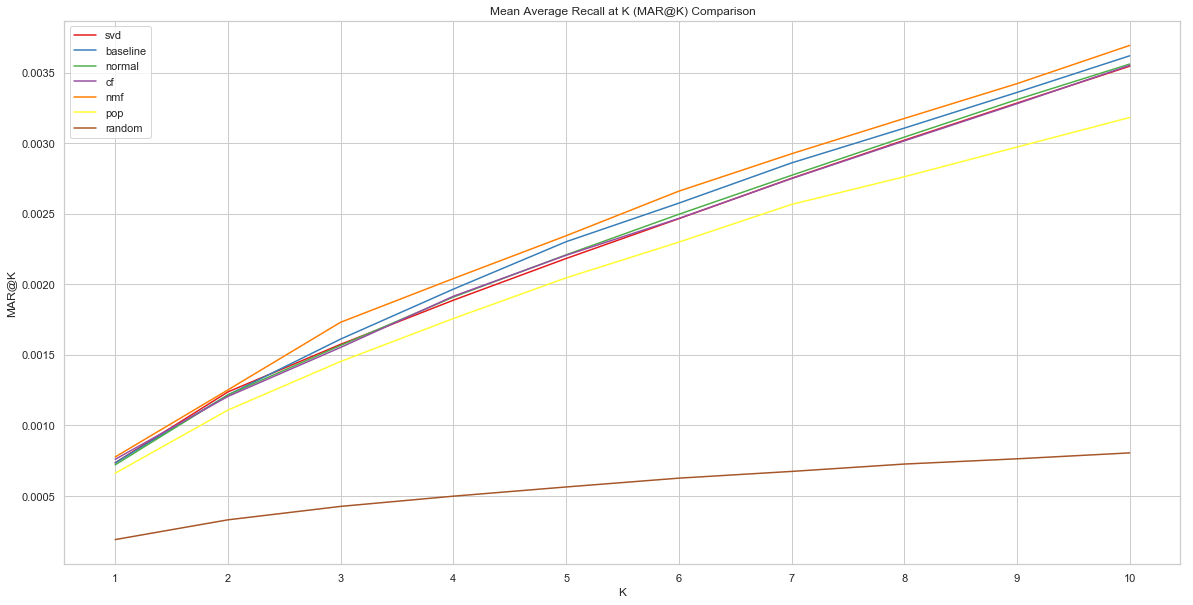

In [496]:
plt.figure(figsize=(20, 10))
mark_plot(marks, model_names=models, k_range=index)

## Coverage

In [497]:
catalog = ratings.movieId.unique().tolist()

coverages = []
for prediction in predictions:
    coverage = catalog_coverage(prediction.values, catalog, k=10)
    coverages.append(coverage)

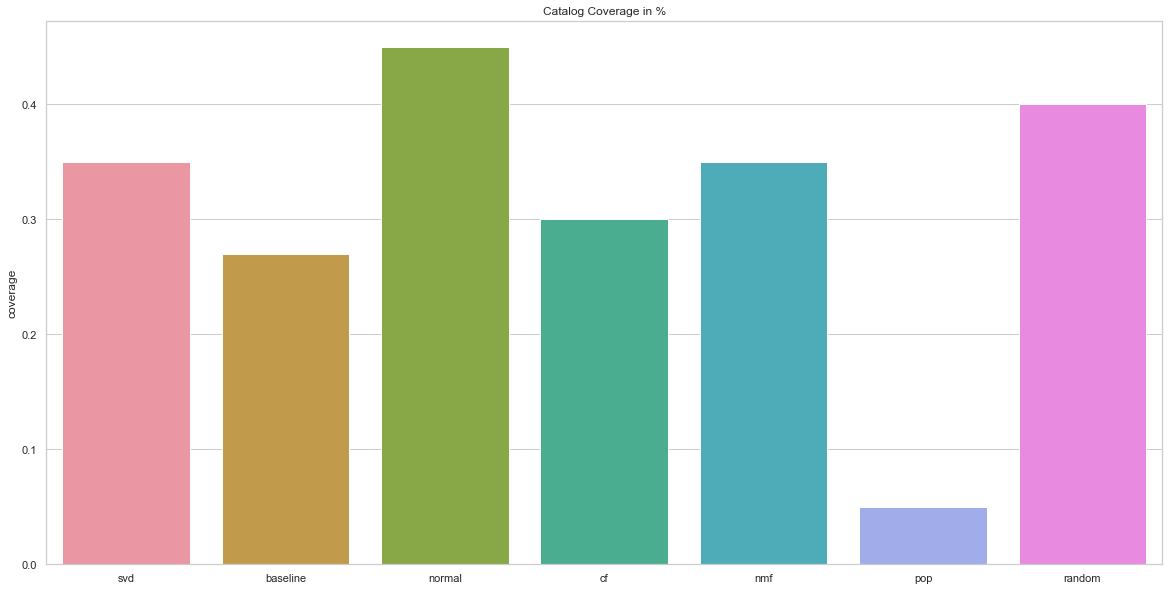

In [498]:
fig = plt.figure(figsize=(20, 10))
coverage_plot(coverages, models)

## Final Remarks

As you can see, learning to rank can be difficult. But for our example non-negative matrix factorization seems to do the best --but only a bit better than a simple baseline. To really improve upon this we need to delve deeply into neural nets (no pun intended) and/or field-aware factorization machines. We could also try to use more developed versions of matrix factorization to improve our scores. There are many variations on theme here.

### IMHO - Never Believe the Hype

Here are my two-cents on the matter. Feel free to take it or leave it.

How well do you see this being done in your day-to-day life by Facebook, Amazon, Google, etc.?

There's a reason why the most naive versions of this are implemented. You can barely do better with an expensive setup. Are FFMs the bee's knees? Yes. Are they that much better than a simple naive baseline? Not typically.

If that's the case, then why try to learn to rank at all? Why not simplify the problem to just a binary classification and then use the predicted probabilities to rank? This methodology tends to work well. 

Here are some examples of this strategy being used:

* https://www.kaggle.com/c/santander-product-recommendation/discussion/26835
* https://www.kaggle.com/c/santander-product-recommendation/discussion/26824
* https://www.kaggle.com/c/santander-product-recommendation/discussion/26899
* https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82036
* https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82314
* https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82093

----

## Further Reading

### LightFM Example on the Same Data

* https://www.kaggle.com/shreyashnadage/lightfm

### NN-based (Learned) Low-Rank Factorization on the Same Data

* https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization

### Metrics

* https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf

* https://github.com/benhamner/Metrics

* http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

### More

* https://github.com/chihming/competitive-recsys

* https://en.wikipedia.org/wiki/Learning_to_rank

* https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html

### Topic-Based Filtering (Bloom) Recommender Model

* https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016

### More on FMs

* https://www.slideshare.net/EvgeniyMarinov/factorization-machines-and-applications-in-recommender-systems

* https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf

* https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/

### Click-Through Rate (CTR) Prediction

* https://arxiv.org/pdf/1806.03514.pdf

### OC-FFM

* https://www.csie.ntu.edu.tw/~cjlin/papers/ocffm/imp_ffm.pdf

### Implementations

* https://github.com/lyst/lightfm

* https://github.com/anttttti/Wordbatch

* https://xlearn-doc.readthedocs.io/en/latest/#

* https://github.com/NicolasHug/Surprise

* https://github.com/Mendeley/mrec

* https://github.com/ocelma/python-recsys

